In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


In [53]:
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather.csv')
spray = pd.read_csv('../assets/spray.csv')
wnv_train = pd.read_csv('../output/train_spray_weather.csv')
wnv_test = pd.read_csv('../output/test_spray_weather.csv')
wnv_trainall = pd.read_csv('../output/train_all.csv')

In [54]:
wnv_trainall.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,HeatMonthAvg,CoolMonthAvg,PrecipMonthAvg,WetBulbMonthAvg,DewPointMonthAvg,DewPoint,WetBulb,Heat,Cool,PrecipTotal
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,3,3,0.0636,55,46,58,65,0,9,0.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,3,3,0.0636,55,46,58,65,0,9,0.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,3,3,0.0636,55,46,58,65,0,9,0.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,3,3,0.0636,55,46,58,65,0,9,0.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,3,3,0.0636,55,46,58,65,0,9,0.0


In [55]:
wnv_train.shape

(10506, 26)

In [7]:
wnv_train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [57]:
# Establishing our baseline accuracy

baseline_accuracy = wnv_train['WnvPresent'].value_counts()[0]/len(wnv_train['WnvPresent'])
baseline_accuracy

0.9475537787930707

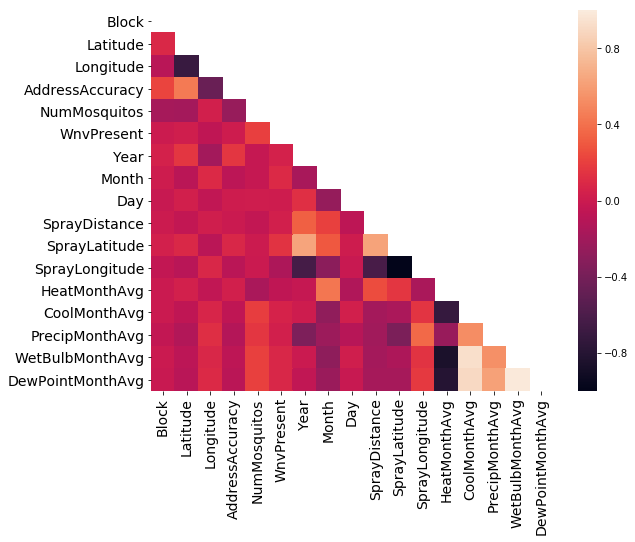

In [59]:
# correlation heatmap

mean_corr = wnv_train.corr()

fig, ax = plt.subplots(figsize=(9,7))

mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [64]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
lbl.fit(list(wnv_train['Species'].values) + list(wnv_test['Species'].values))
wnv_train['Species'] = lbl.transform(wnv_train['Species'].values)
wnv_test['Species'] = lbl.transform(wnv_test['Species'].values)

lbl.fit(list(wnv_train['Trap'].values) + list(wnv_test['Trap'].values))
wnv_train['Trap'] = lbl.transform(wnv_train['Trap'].values)
wnv_test['Trap'] = lbl.transform(wnv_test['Trap'].values)

lbl.fit(list(wnv_train['HeatMonthAvg'].values) + list(wnv_test['HeatMonthAvg'].values))
wnv_train['HeatMonthAvg'] = lbl.transform(wnv_train['HeatMonthAvg'].values)
wnv_test['HeatMonthAvg'] = lbl.transform(wnv_test['HeatMonthAvg'].values)

lbl.fit(list(wnv_train['CoolMonthAvg'].values) + list(wnv_test['CoolMonthAvg'].values))
wnv_train['CoolMonthAvg'] = lbl.transform(wnv_train['CoolMonthAvg'].values)
wnv_test['CoolMonthAvg'] = lbl.transform(wnv_test['CoolMonthAvg'].values)

lbl.fit(list(wnv_train['PrecipMonthAvg'].values) + list(wnv_test['PrecipMonthAvg'].values))
wnv_train['PrecipMonthAvg'] = lbl.transform(wnv_train['PrecipMonthAvg'].values)
wnv_test['PrecipMonthAvg'] = lbl.transform(wnv_test['PrecipMonthAvg'].values)

lbl.fit(list(wnv_train['WetBulbMonthAvg'].values) + list(wnv_test['WetBulbMonthAvg'].values))
wnv_train['WetBulbMonthAvg'] = lbl.transform(wnv_train['WetBulbMonthAvg'].values)
wnv_test['WetBulbMonthAvg'] = lbl.transform(wnv_test['WetBulbMonthAvg'].values)

lbl.fit(list(wnv_train['DewPointMonthAvg'].values) + list(wnv_test['DewPointMonthAvg'].values))
wnv_train['DewPointMonthAvg'] = lbl.transform(wnv_train['DewPointMonthAvg'].values)
wnv_test['DewPointMonthAvg'] = lbl.transform(wnv_test['DewPointMonthAvg'].values)


In [61]:
wnv_test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Year', 'Month', 'Day', 'Weather_Info', 'HeatMonthAvg', 'CoolMonthAvg',
       'PrecipMonthAvg', 'WetBulbMonthAvg', 'DewPointMonthAvg'],
      dtype='object')

In [65]:
X = wnv_train[['Species', 'Trap', 'HeatMonthAvg', 
              'CoolMonthAvg', 'PrecipMonthAvg', 'DewPointMonthAvg']]
y = wnv_train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [66]:
rfc_params={
    'n_estimators':[5,10,15,20],
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,None]}

rfc_gridsearch = GridSearchCV(RandomForestClassifier(), rfc_params, verbose=1, cv=5, n_jobs=4)
rfc_gridsearch.fit(X_train,y_train)

print('GridSearch score:',rfc_gridsearch.best_score_)
print('Best Parameters:', rfc_gridsearch.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearch score: 0.947074501840335
Best Parameters: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 5}


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.7s finished


In [67]:
# Random Forest Model

rfc_wnv = RandomForestClassifier(max_depth=None,
                                 n_estimators=10)
rfc_wnv.fit(X_train,y_train)

score_rfc_wnv = rfc_wnv.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_wnv = cross_val_score(rfc_wnv, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_rfc_wnv)
print('Cross Validation Score:', cv_wnv)

Baseline: 0.9475537787930707
Random Forrest Score: 0.9429006471259992
Cross Validation Score: 0.9212108282781374


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [68]:
y_preds = rfc_wnv.predict(X_test)

rfc_df_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rfc_df_confusion

Predicted,0,1,All
Actual,,,
0,2458,35,2493
1,115,19,134
All,2573,54,2627


In [74]:
x = wnv_test[['Species', 'Trap', 'HeatMonthAvg', 
              'CoolMonthAvg', 'PrecipMonthAvg', 'DewPointMonthAvg']]



array([0.98333333, 0.01666667])

In [69]:
pd.DataFrame(rfc_wnv.predict_proba(x))[1]

0         0.034286
1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11        0.000000
12        0.000000
13        0.000000
14        0.000000
15        0.000000
16        0.000000
17        0.000000
18        0.000000
19        0.000000
20        0.000000
21        0.000000
22        0.000000
23        0.000000
24        0.000000
25        0.000000
26        0.000000
27        0.000000
28        0.000000
29        0.000000
            ...   
116263    0.000000
116264    0.000000
116265    0.000000
116266    0.000000
116267    0.000000
116268    0.000000
116269    0.000000
116270    0.000000
116271    0.000000
116272    0.000000
116273    0.000000
116274    0.000000
116275    0.000000
116276    0.000000
116277    0.000000
116278    0.000000
116279    0.000000
116280    0.000000
116281    0.000000
116282    0.000000
116283    0.000000
116284    0.

### RFC with daily weather data

In [51]:
lbl2 = LabelEncoder()
lbl2.fit(list(wnv_trainall['Species'].values) + list(wnv_test['Species'].values))
wnv_trainall['Species'] = lbl2.transform(wnv_trainall['Species'].values)
wnv_test['Species'] = lbl2.transform(wnv_test['Species'].values)

lbl2.fit(list(wnv_trainall['Trap'].values) + list(wnv_test['Trap'].values))
wnv_trainall['Trap'] = lbl2.transform(wnv_trainall['Trap'].values)
wnv_test['Trap'] = lbl2.transform(wnv_test['Trap'].values)


#### Building a Keras NN

In [70]:
y_train = y_train.reshape(-1,1)

/Users/reef/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [71]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [72]:
y_train.shape

(7879, 2)

In [81]:
model_1 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_1.add(Dense(n_hidden,
                  input_dim= n_input,
                  activation='relu'))
model_1.add(Dropout(.2))
model_1.add(Dense(n_hidden,
                  activation='relu'))            

model_1.add(Dense(n_output,
                  activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [82]:
hist_1 = model_1.fit(X_train,y_train,
                 validation_data=(X_test,y_test),
                 epochs=20,
                 verbose=1)

Train on 7879 samples, validate on 2627 samples
Epoch 1/20
7879/7879 [==============================] - 1s 154us/step - loss: 0.4923 - acc: 0.9134 - val_loss: 0.2622 - val_acc: 0.9490
Epoch 2/20
7879/7879 [==============================] - 1s 71us/step - loss: 0.2772 - acc: 0.9464 - val_loss: 0.2312 - val_acc: 0.9490
Epoch 3/20
7879/7879 [==============================] - 1s 75us/step - loss: 0.2415 - acc: 0.9471 - val_loss: 0.2230 - val_acc: 0.9490
Epoch 4/20
7879/7879 [==============================] - 1s 75us/step - loss: 0.2343 - acc: 0.9471 - val_loss: 0.2182 - val_acc: 0.9490
Epoch 5/20
7879/7879 [==============================] - 1s 76us/step - loss: 0.2267 - acc: 0.9471 - val_loss: 0.2131 - val_acc: 0.9490
Epoch 6/20
7879/7879 [==============================] - 1s 76us/step - loss: 0.2255 - acc: 0.9471 - val_loss: 0.2122 - val_acc: 0.9490
Epoch 7/20
7879/7879 [==============================] - 1s 70us/step - loss: 0.2191 - acc: 0.9471 - val_loss: 0.2127 - val_acc: 0.9490
Epoch 

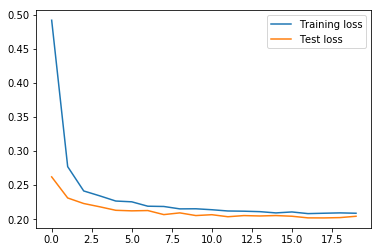

In [83]:
plt.plot(hist_1.history['loss'], label='Training loss')
plt.plot(hist_1.history['val_loss'], label='Test loss')
plt.legend()

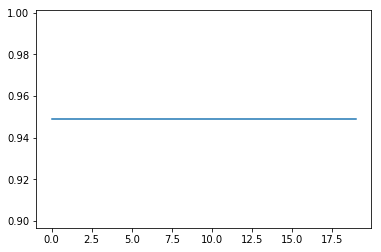

In [84]:
plt.plot(hist_1.history['val_acc'])

In [80]:
pred_list = model_1.predict_classes(X_test)

actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))
    
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras_confusion = pd.crosstab(actual_list, pred_list, rownames=['Actual'], colnames=['Predicted'], margins=True)
keras_confusion

Predicted,0,All
Actual,,
0,2493,2493
1,134,134
All,2627,2627
